<a href="https://colab.research.google.com/github/mahalrupi/EIP-4.0/blob/master/Week5/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os


Using TensorFlow backend.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True,augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        if self.augmentation is not None:
            image = self.augmentation.flow(image, shuffle=False).next()
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,random_state=30)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [7]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10297,resized/10299.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0
8668,resized/8669.jpg,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
1412,resized/1413.jpg,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
9059,resized/9060.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
9474,resized/9475.jpg,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, augmentation=ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True  ))
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False)

In [9]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
data_augmentation = True
subtract_pixel_mean = True
n = 5

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    Input
    inputs = Input(shape=input_shape)
  
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    y = GlobalAveragePooling2D(data_format='channels_last')(x)
    outputs = Dense(512,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    mode = Model(inputs=inputs, outputs=outputs)
    return mode

In [12]:
backbone = resnet_v1((224,224,3), depth=depth)

In [13]:
backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [14]:


neck = backbone.output
#neck = Flatten(name="flatten")(neck)
#neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
# freeze backbone
#for layer in backbone.layers:
#	layer.trainable = False

In [16]:
losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",

 }
#loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 0.5}
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    #loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:

from keras.callbacks import Callback
from keras import backend as K
import numpy as np


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.
    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # References
      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)
MIN_LR = 1e-4
MAX_LR = 3e-2

STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 96

clr = CyclicLR(
	mode=CLR_METHOD,
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size= STEP_SIZE * (train_df.shape[0] // 32))
  

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 45:
        lr *= 0.5e-3
    elif epoch > 40:
        lr *= 1e-3
    elif epoch > 35:
        lr *= 1e-2
    elif epoch > 25:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

model_name = 'cifar10_%s_model.{epoch:03d}.h5'
save_dir = F"/content/gdrive/My Drive/models3"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, clr,lr_reducer]


In [0]:
import math
import os
import numpy as np
import warnings
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import backend as K

import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import pandas as pd


import matplotlib.pyplot as plt
def detect_local_minima(arr):
    # https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array
    # https://stackoverflow.com/questions/3986345/how-to-find-the-local-minima-of-a-smooth-multidimensional-array-in-numpy-efficien
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape), 2)
    # apply the local minimum filter; all locations of minimum value
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood) == arr)
    # local_min is a mask that contains the peaks we are
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    #
    # we create the mask of the background
    background = (arr == 0)
    #
    # a little technicality: we must erode the background in order to
    # successfully subtract it from local_min, otherwise a line will
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    #
    # we obtain the final mask, containing only peaks,
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)


def moving_average_fast(x, w):
    # https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
    return np.convolve(np.array(x), np.ones(w), 'same') / w


def moving_average(x, w):
    df = pd.DataFrame({"x": x})
    return df.rolling(w, win_type=None, min_periods=1, center=True).mean()['x'].values

def get_derivatives(vals, sma=10):
    assert sma >= 1
    derivatives = [0] * sma
    losses = moving_average(vals, 5)
    for i in range(sma, len(vals)):
        derivatives.append((losses[i] - losses[i - sma]) / sma)
    return derivatives
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model, num_validation_batches=10):
        self.model = model
        self.losses = []
        self.acc = []
        self.lrs = []
        self.best_loss = 1e9
        self.best_acc = 0
        self.one_minus_acc = []
        self.one_minus_acc_best = []
        self.num_validation_batches = num_validation_batches
        self.validation_set = None
        self.validation_generator = None

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        acc = logs['gender_output_acc']

        self.losses.append(loss)
        self.acc.append(acc)
        self.one_minus_acc.append(1 - acc)

        # Check whether the loss got too large or NaN
        if batch > 16 and (math.isnan(loss) or loss > self.best_loss * 10):
            self.model.stop_training = True
            print("Stop Training at %s, loss = %.3f" % (batch, loss))
            return

        if loss < self.best_loss:
            self.best_loss = loss
        if acc > self.best_acc:
            self.best_acc = acc

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr,
             x_test=None, y_test=None,
             batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))
        self.validation_set = (x_test, y_test) if x_test is not None and y_test is not None else None
        self.batch_size = batch_size

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       verbose=0,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr,
                       test_generator=None,
                       epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch * epochs))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.validation_generator = test_generator

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 verbose=0,
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=5, n_skip_end=5, sma=20):
        self.__plot__(n_skip_beginning,n_skip_end,sma,use_acc=False)

    def plot_one_minus_acc(self, n_skip_beginning=5, n_skip_end=5, sma=20):
        self.__plot__(n_skip_beginning,n_skip_end,sma,use_acc=True)

    def __plot__(self, n_skip_beginning=5, n_skip_end=5, sma=10, use_acc=False):

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111)
        y_label = "1 - Acc" if use_acc else "loss"
        plt.ylabel(y_label)
        plt.xlabel("learning rate (log scale)")

        losses = self.losses if not use_acc else self.one_minus_acc
        losses = moving_average(losses, sma)

        losses = losses[n_skip_beginning:-n_skip_end]

        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], losses)
        plt.xscale('log')
        best_lrs = self.get_best_lrs(sma,use_acc=use_acc)
        lrs = [x for x, _ in best_lrs]
        positions = [x for _, x in best_lrs]
        # https://matplotlib.org/users/annotations_intro.html
        # for lr, pos in [best_lrs[-1]]:
        #     ax.annotate('LR = %.3f, %s = %.2f' % (lr, y_label, losses[pos]), xy=(lr, losses[pos]),
        #                 xytext=(lr + 0.2, losses[pos] + 0.1),
        #                 arrowprops=dict(facecolor='black', shrink=0.03, width=1, frac=0.05),
        #                 )

        title = "LR vs 1 - Acc Graph" if use_acc else "LR vs Loss Graph"
        # title = title + "\n" + "Best Candidate LR = %s" % lrs
        plt.title(title)
        plt.show()

    def __get_best_lr_method1__(self, sma=20, n_skip_beginning=10, n_skip_end=5, use_acc=False):
        losses = self.losses if not use_acc else self.one_minus_acc
        derivatives = get_derivatives(losses, sma)
        losses = np.array(losses[n_skip_beginning:-n_skip_end])
        derivatives = derivatives[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]

        best_loss = (1 - self.best_acc) if use_acc else self.best_loss
        acceptable_idxs = np.where(losses <= best_loss * 1.75)[0]

        derivatives = derivatives[acceptable_idxs[0]:acceptable_idxs[-1]]

        best_idxs = np.argpartition(derivatives, -5)[-5:]
        best_idxs = best_idxs - sma + acceptable_idxs[0]
        acceptable_loss_or_not = losses[best_idxs] <= best_loss * 1.5
        best_idxs = best_idxs[acceptable_loss_or_not]

        acceptable_loss_or_not = losses[best_idxs + sma] > (losses[best_idxs] * 1.0)
        best_idxs = best_idxs[acceptable_loss_or_not]

        candidates = list(np.array(lrs)[best_idxs])
        return sorted(candidates), best_idxs

    def get_best_lrs(self, sma=20, n_skip_beginning=10, n_skip_end=5, use_acc=False):
        c1, i1 = self.__get_best_lr_method1__(sma, n_skip_beginning, n_skip_end, use_acc)
        candidates = list(zip(c1, i1))
        candidates = sorted(candidates, key=lambda pair: pair[0])
        final_candidates = [candidates[0]]
        for v, i in candidates:
            if (v - final_candidates[-1][0]) / final_candidates[-1][0] > 0.2:
                final_candidates.append((v, i))
        final_candidates = list(map(lambda pair: (float("%.3f" % pair[0]), pair[1]), final_candidates))
        return final_candidates


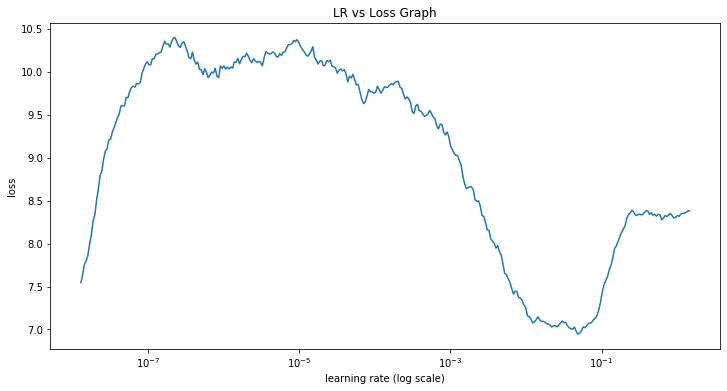

In [33]:
lrf = LRFinder(model)
lrf.find_generator(train_gen, 0.00000001, 2.0,valid_gen, epochs=1, steps_per_epoch=None,)
lrf.plot_loss()

In [29]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=96,
    steps_per_epoch=train_df.shape[0] // 32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/96
360/360 [==============================] - 139s 386ms/step - loss: 9.0285 - gender_output_loss: 0.6024 - image_quality_output_loss: 1.1525 - age_output_loss: 1.4580 - weight_output_loss: 1.4327 - bag_output_loss: 0.9697 - footwear_output_loss: 0.9928 - pose_output_loss: 1.2432 - emotion_output_loss: 0.9947 - gender_output_acc: 0.6723 - image_quality_output_acc: 0.4652 - age_output_acc: 0.3889 - weight_output_acc: 0.4818 - bag_output_acc: 0.5234 - footwear_output_acc: 0.5528 - pose_output_acc: 0.4444 - emotion_output_acc: 0.7116 - val_loss: 8.4480 - val_gender_output_loss: 0.6126 - val_image_quality_output_loss: 0.9752 - val_age_output_loss: 1.4094 - val_weight_output_loss: 1.0192 - val_bag_output_loss: 0.9044 - val_footwear_output_loss: 1.5122 - val_pose_output_loss: 0.9207 - val_emotion_output_loss: 0.9120 - val_gender_output_acc: 0.6483 - val_image_quality_output_acc: 0.5432 - val_age_output_acc: 0.4003 - val_weight_output_acc: 0.6111 - val_bag_output_acc: 0.5729 - val_foo

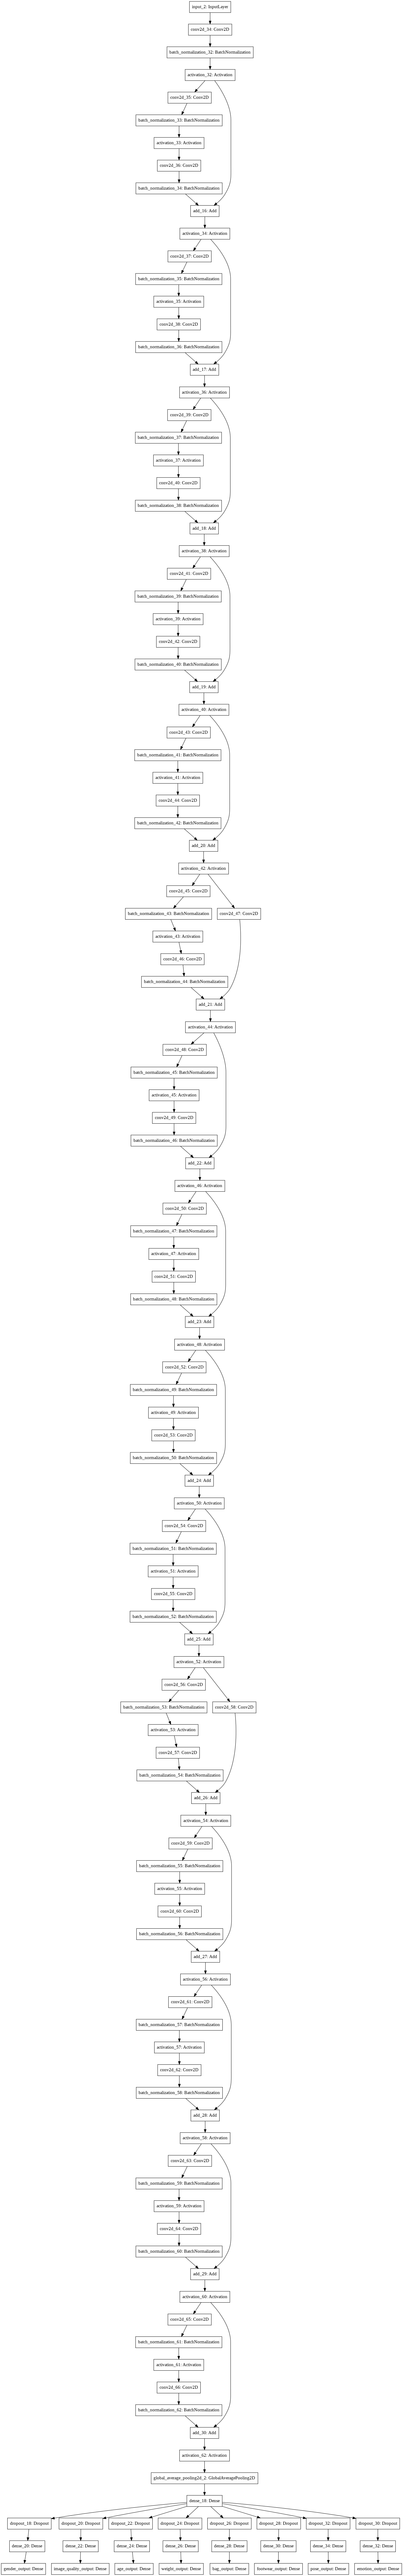

In [0]:
from keras.utils import plot_model
plot_model(model)
#, to_file='model.png'

In [30]:
def evaluate_model(model):
    results = model.evaluate_generator(valid_gen, verbose=1)
    accuracies = {}
    losses = {}
    for k, v in zip(model.metrics_names, results):
        if k.endswith('acc'):
            accuracies[k] = round(v * 100, 4) 
        else:
            losses[k] = v
    return accuracies
print(evaluate_model(model))

63/63 [==============================] - 7s 116ms/step
{'gender_output_acc': 87.6488, 'image_quality_output_acc': 57.0437, 'age_output_acc': 39.7321, 'weight_output_acc': 61.1111, 'bag_output_acc': 61.3095, 'footwear_output_acc': 68.502, 'pose_output_acc': 79.7619, 'emotion_output_acc': 71.3294}
